In [2]:
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import sqlalchemy as sa
from sqlalchemy.engine.url import URL

load_dotenv('../.env')

url = URL.create(
    drivername="mysql",
    username=os.getenv('USER'),
    password=os.getenv('PIN'),
    host=os.getenv('HOST'),
    port=int(os.getenv('PORT')),
    database=os.getenv('DB'),
    query={"charset": "utf8"}
)

# engine作成
engine = sa.create_engine(url, echo=False)

# pandasのread_sql関数にselect文とengineを指定する
query = f"select p.`condition`, c.`row`, c.`column`, c.pieceName, c.pieceID, c.drawCount / c.throughCount as probabilityOfDraw, c.firstWinCount / c.throughCount as probabilityOfFirstWin, c.secondWinCount / c.throughCount as probabilityOfSecondWin from {os.getenv('DB')}.{os.getenv('TABLENAME')} as c join {os.getenv('DB')}.{os.getenv('TABLENAME')} as p on c.parentID = p.ID where p.`condition` is not null order by c.throughCount desc limit 1000000;"
df = pd.read_sql(query, con=engine)

print(df)

                                                condition  row  column  \
0       b"\x0f9\xc64\xa6\x10\xa8\x99Cju\x8f\xb8\x00\xa...    6       4   
1       b"\x0f9\xc64\xa6\x10\xa8\x99Cju\x8f\xb8\x00\xa...    6       3   
2       b"\x0f9\xc64\xa6\x10\xa8\x99Cju\x8f\xb8\x00\xa...    8       5   
3       b"\x0f9\xc64\xa6\x10\xa8\x99Cju\x8f\xb8\x00\xa...    8       9   
4       b"\x0f9\xc64\xa6\x10\xa8\x99Cju\x8f\xb8\x00\xa...    6       7   
...                                                   ...  ...     ...   
999995  b'\r,\xde\x80\x16\xd4\x00c\xe9[\x00 \x04\x00\x...    2       9   
999996  b"\r,k\x80\x16R\x00@\x08\x01'.\xe4\x00\xb9\x90...    6       9   
999997  b'\x00\x05b\x00\x10\x02\x00X@\x01u\x80\x05\xe7...    3       5   
999998  b'\x00\x04\x00\xae`\x02\x00V \x01\x000u\xe7\x0...    1       9   
999999  b"\x0f9\xc64\xa0\x02\xa8\x99Cju\x8f\xb8\x00\xa...    2       1   

        pieceName  pieceID  probabilityOfDraw  probabilityOfFirstWin  \
0               7       15             

In [3]:
rows = {1: 'row1', 2: 'row2', 3: 'row3', 4: 'row4', 5: 'row5', 6: 'row6', 7: 'row7', 8: 'row8', 9: 'row9'}
columns = {1: 'cone', 2: 'column2', 3: 'column3', 4: 'column4', 5: 'column5', 6: 'column6', 7: 'column7', 8: 'column8', 9: 'column9'}
pieceNames = {0: 'king', 1: 'rook', 2: 'bichop', 3: 'goldgengral', 4: 'silvergeneral', 5: 'knight', 6: 'lance', 7: 'pawn', 8: 'promoted_rook', 9: 'promoted_bichop', 10: 'promoted_silvergeneral', 11: 'promoted_knight', 12: 'promoted_lance', 13: 'promoted_pawn'}
pieceIds = {}
for i in range(1, 41):
    pieceIds[i] = f"pid{i}"

In [4]:
binarray = []
for i in df['condition']:
    bin = []
    for j in i:
        str = f"{j:0=8b}"
        for k in str:
            bin.append(float(k))
    del bin[0:3]
    binarray.append(bin)

ds_input_condition = pd.DataFrame(binarray)
ds_input_row = df[['row']]
ds_input_column = df[['column']]
ds_input_pieceName = df[['pieceName']]
ds_input_pieceId = df[['pieceID']]
ds_output_probability = df[['probabilityOfDraw', 'probabilityOfFirstWin', 'probabilityOfSecondWin']]

ds_input_row['row'] = ds_input_row['row'].map(rows)
ds_input_row = pd.get_dummies(ds_input_row, columns=['row'], prefix='', prefix_sep='')
ds_input_column['column'] = ds_input_column['column'].map(columns)
ds_input_column = pd.get_dummies(ds_input_column, columns=['column'], prefix='', prefix_sep='')
ds_input_pieceName['pieceName'] = ds_input_pieceName['pieceName'].map(pieceNames)
ds_input_pieceName = pd.get_dummies(ds_input_pieceName, columns=['pieceName'], prefix='', prefix_sep='')
ds_input_pieceId['pieceID'] = ds_input_pieceId['pieceID'].map(pieceIds)
ds_input_pieceId = pd.get_dummies(ds_input_pieceId, columns=['pieceID'], prefix='', prefix_sep='')

In [15]:
ds_output_probability

,probabilityOfDraw,probabilityOfFirstWin,probabilityOfSecondWin
0,0.0060,0.5299,0.4641
1,0.0062,0.5216,0.4723
2,0.0145,0.4617,0.5238
3,0.0041,0.4896,0.5062
4,0.0167,0.4791,0.5042
...,...,...,...
99995,0.0000,1.0000,0.0000
99996,0.0000,0.0000,1.0000
99997,0.0000,0.0000,1.0000
99998,0.0000,0.0000,1.0000


In [16]:
print(ds_input_condition.shape)
print(ds_input_row.shape)
print(ds_input_column.shape)
print(ds_input_pieceName.shape)
print(ds_input_pieceId.shape)
print(ds_output_probability.shape)

(100000, 1341)
(100000, 9)
(100000, 9)
(100000, 14)
(100000, 40)
(100000, 3)


In [17]:
import tensorflow as tf

input_condition = tf.keras.Input(shape=1341)
input_row = tf.keras.Input(shape=9)
input_column = tf.keras.Input(shape=9)
input_pieceName = tf.keras.Input(shape=14)
input_pieceId = tf.keras.Input(shape=40)
inputs = tf.keras.layers.concatenate([input_condition, input_row, input_column, input_pieceName, input_pieceId])
hide1 = tf.keras.layers.Dense(1413, activation="relu")(inputs)
hide2 = tf.keras.layers.Dense(1413, activation="relu")(hide1)
output_probability = tf.keras.layers.Dense(3, name="output")(hide2)
model = tf.keras.Model(inputs= [input_condition, input_row, input_column, input_pieceName, input_pieceId], outputs= output_probability)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1341)]               0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 14)]                 0         []                            
                                                                                            

In [18]:
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])

In [27]:
model = tf.keras.models.load_model('saved_model/probability')

# history = model.fit([
#     ds_input_condition,
#     ds_input_row,
#     ds_input_column,
#     ds_input_pieceName,
#     ds_input_pieceId
# ], ds_output_probability, epochs=90)

# model.save('saved_model/probability')

Epoch 1/90
3125/3125 [==============================] - 48s 15ms/step - loss: 0.0381 - accuracy: 0.9543
Epoch 2/90
3125/3125 [==============================] - 48s 15ms/step - loss: 0.0346 - accuracy: 0.9611
Epoch 3/90
3125/3125 [==============================] - 47s 15ms/step - loss: 0.0319 - accuracy: 0.9644
Epoch 4/90
3125/3125 [==============================] - 48s 15ms/step - loss: 0.0291 - accuracy: 0.9684
Epoch 5/90
3125/3125 [==============================] - 48s 15ms/step - loss: 0.0272 - accuracy: 0.9715
Epoch 6/90
3125/3125 [==============================] - 48s 15ms/step - loss: 0.0253 - accuracy: 0.9736
Epoch 7/90
3125/3125 [==============================] - 47s 15ms/step - loss: 0.0236 - accuracy: 0.9758
Epoch 8/90
3125/3125 [==============================] - 47s 15ms/step - loss: 0.0222 - accuracy: 0.9780
Epoch 9/90
3125/3125 [==============================] - 47s 15ms/step - loss: 0.0209 - accuracy: 0.9791
Epoch 10/90
3125/3125 [==============================] - 47s 15m

INFO:tensorflow:Assets written to: saved_model/probability\assets


[0.0381285585463047, 0.03461631387472153, 0.03191802650690079, 0.029104452580213547, 0.027232838794589043, 0.025296708568930626, 0.02357231266796589, 0.022189710289239883, 0.02088886685669422, 0.01968780905008316, 0.018608136102557182, 0.017536092549562454, 0.016621680930256844, 0.015787893906235695, 0.015068918466567993, 0.01458804216235876, 0.013821849599480629, 0.01336284913122654, 0.012774518691003323, 0.012125693261623383, 0.011853768490254879, 0.011321301572024822, 0.01082251500338316, 0.010665644891560078, 0.010202676057815552, 0.009819182567298412, 0.00946722086519003, 0.009240832179784775, 0.008982842788100243, 0.008668042719364166, 0.00851467251777649, 0.008268152363598347, 0.008066851645708084, 0.007756729610264301, 0.007494858466088772, 0.007352541666477919, 0.0071081737987697124, 0.00698449881747365, 0.006868151016533375, 0.006624476984143257, 0.006442764773964882, 0.006321294698864222, 0.006257966160774231, 0.00605727918446064, 0.005889866501092911, 0.005772617645561695, 

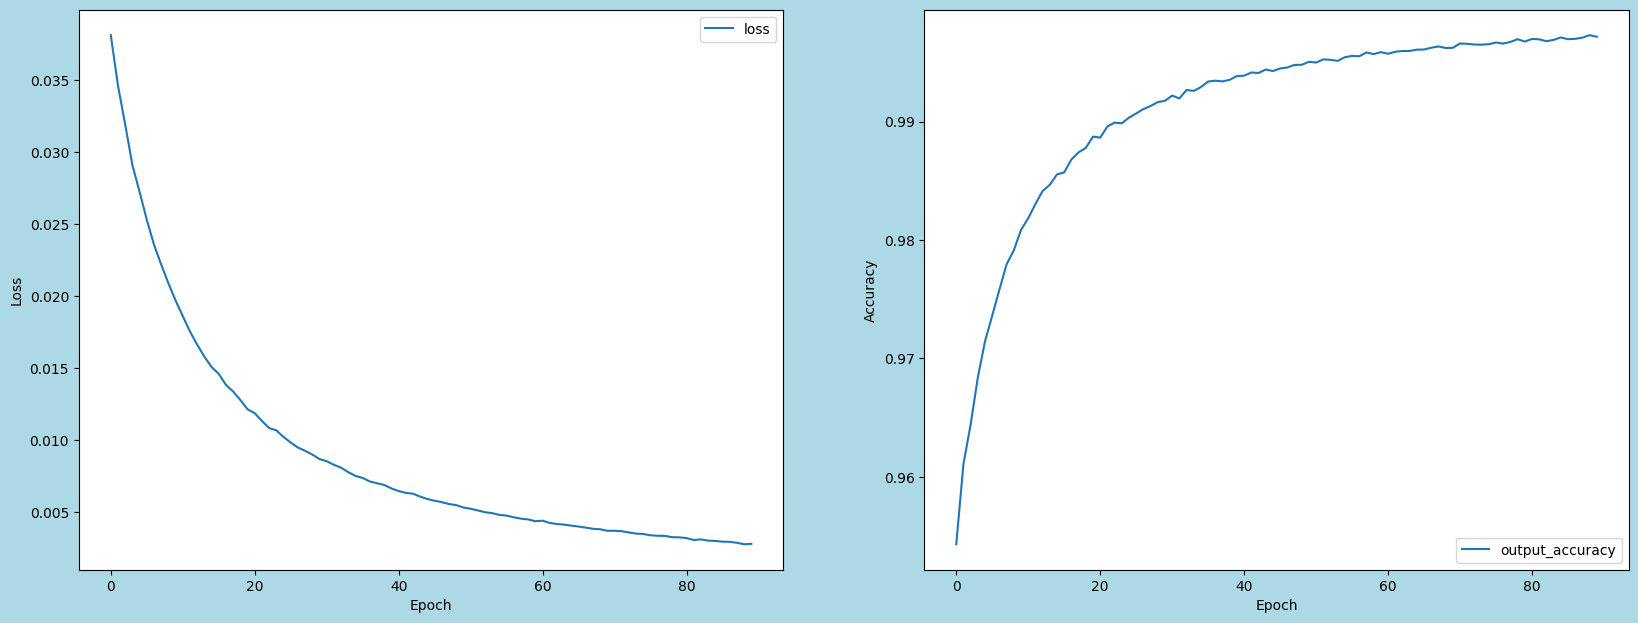

In [28]:
import matplotlib.pyplot as plt

print(history.history['loss'])
print(history.history['accuracy'])

fig = plt.figure(figsize = (20, 16), facecolor= 'lightblue')
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

ax1.plot(history.history['loss'], label='loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

ax2.plot(history.history['accuracy'], label='output_accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

In [1]:
predictions = model.predict([
    ds_input_condition.loc[0],
    ds_input_row.loc[0],
    ds_input_column.loc[0],
    ds_input_pieceName.loc[0],
    ds_input_pieceId.loc[0]
])

NameError: name 'model' is not defined

              draw     first   second
teach     0.000000  1.000000  0.00000
generate -0.020977  1.017369  0.00362
delta     0.020977 -0.017369 -0.00362
              draw     first    second
teach     0.000000  1.000000  0.000000
generate -0.017553  1.010918  0.007017
delta     0.017553 -0.010918 -0.007017
             draw     first   second
teach     0.00000  0.000000  1.00000
generate -0.00903  0.011122  1.00352
delta     0.00903 -0.011122 -0.00352
              draw    first   second
teach     0.000000  1.00000  0.00000
generate -0.076641  1.14089 -0.06061
delta     0.076641 -0.14089  0.06061
              draw     first    second
teach     0.000000  0.000000  1.000000
generate  0.025086 -0.036738  1.027477
delta    -0.025086  0.036738 -0.027477
              draw     first    second
teach     0.000000  0.000000  1.000000
generate -0.005183  0.000009  0.993552
delta     0.005183 -0.000009  0.006448
             draw    first    second
teach     0.00000  0.00000  1.000000
generate -

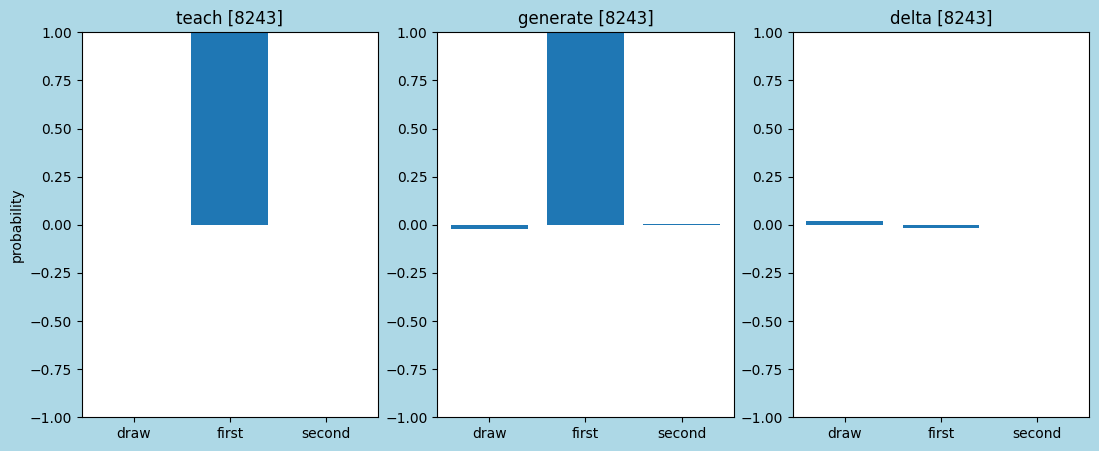

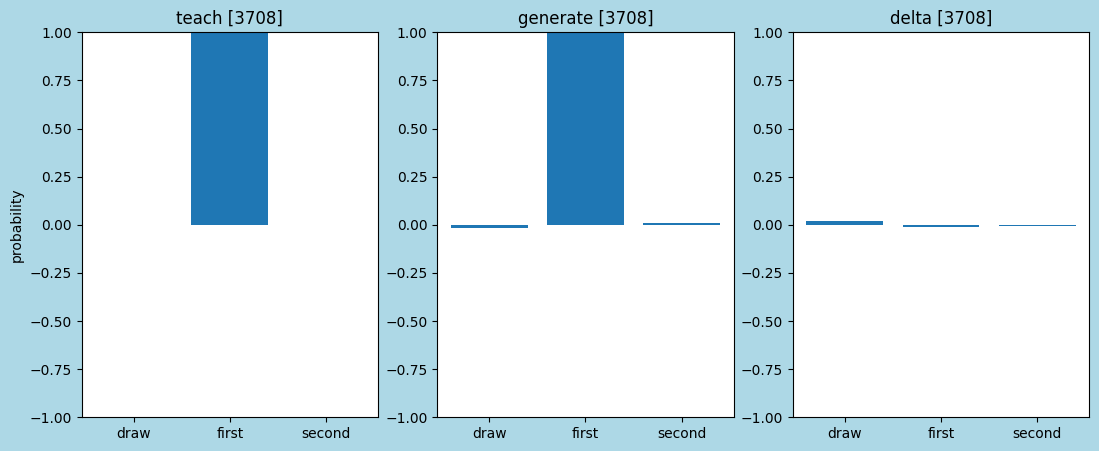

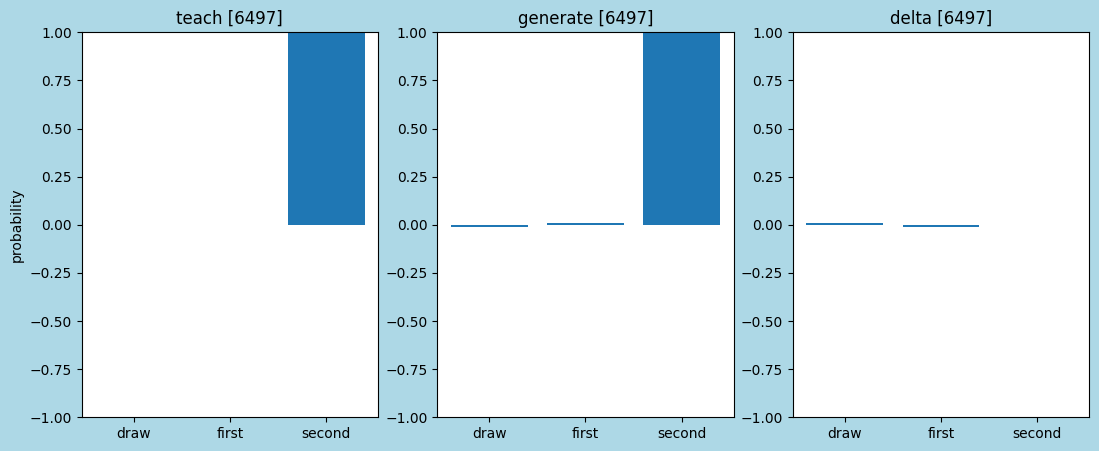

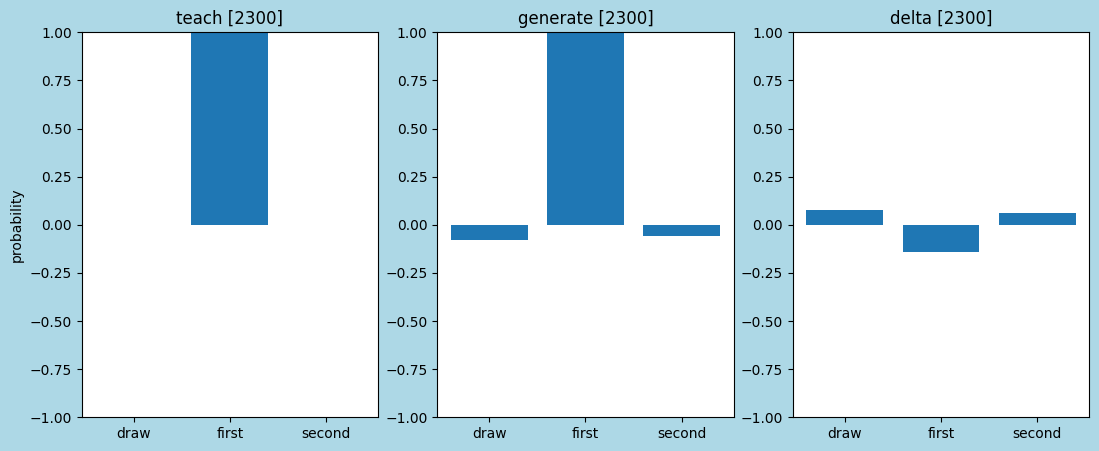

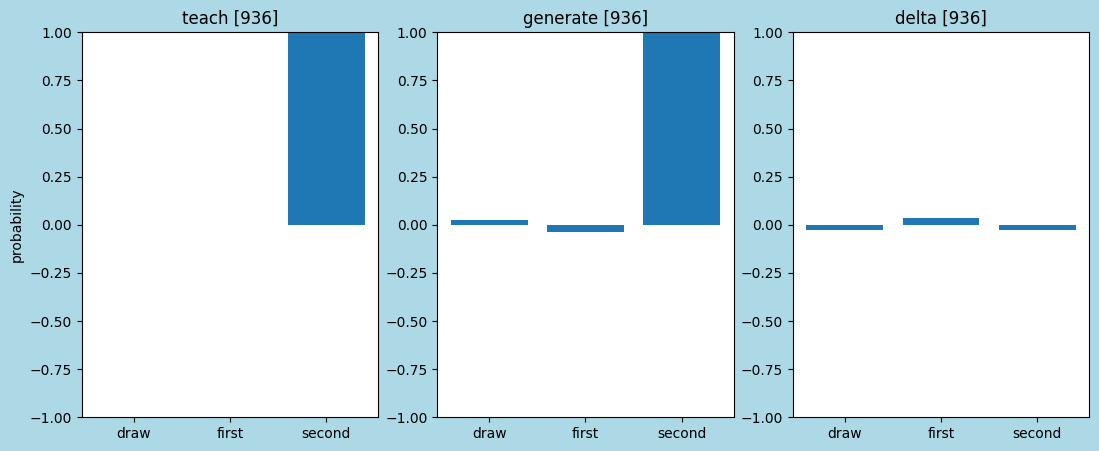

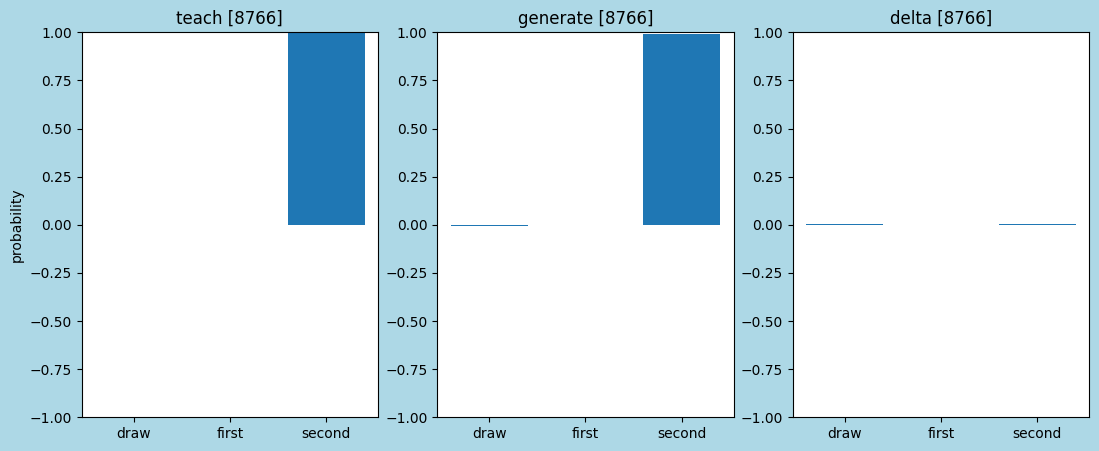

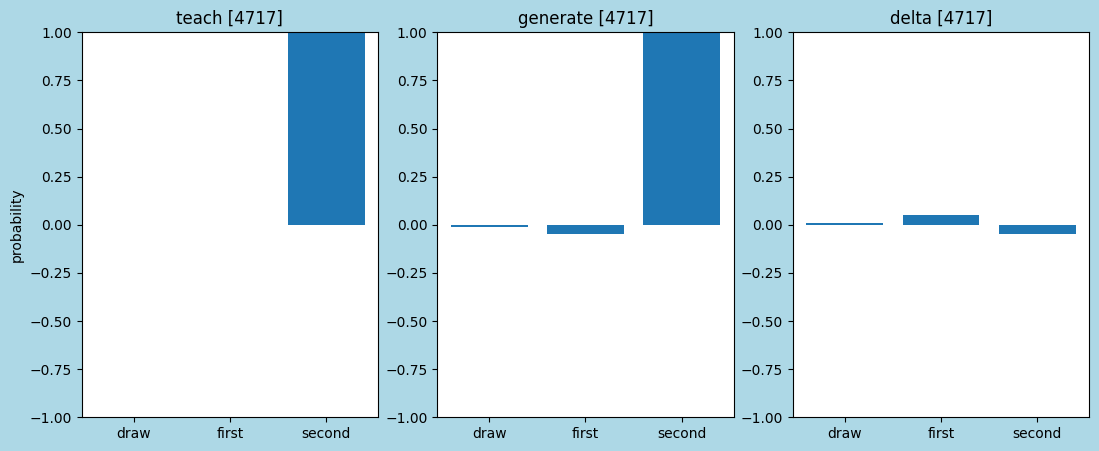

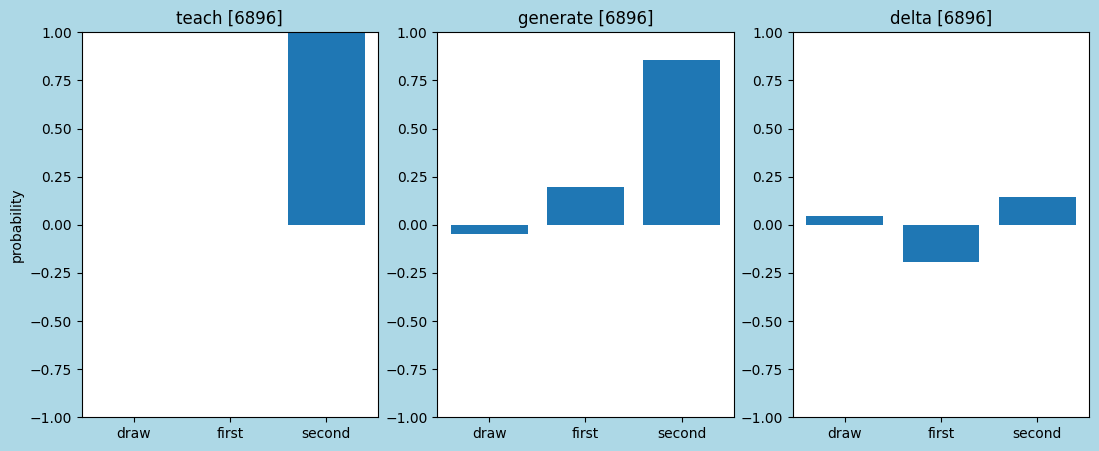

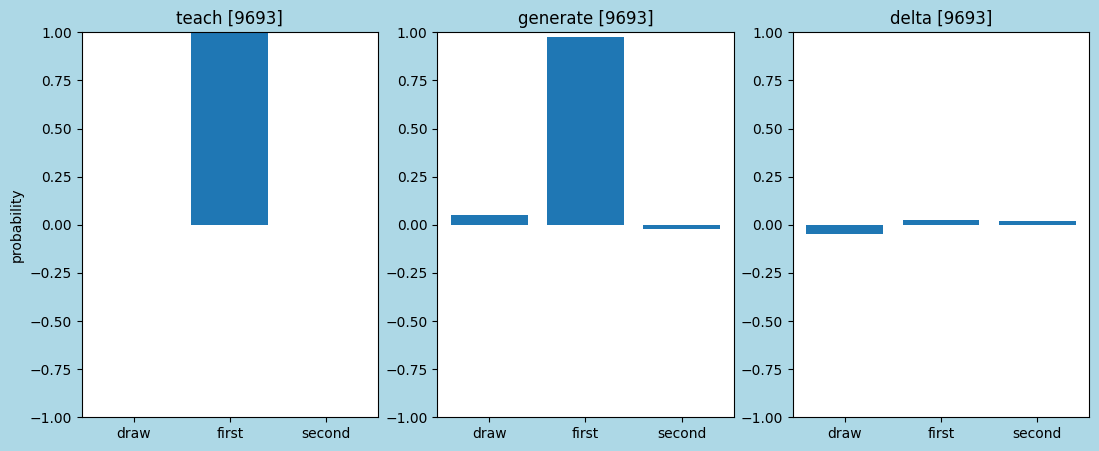

In [31]:
import random

for i in range(9):
    index = random.randint(1, 10000)

    label = ['draw', 'first', 'second']

    fig = plt.figure(figsize = (13, 5), facecolor= 'lightblue')
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)

    teach = ds_output_probability.loc[index].to_numpy().astype(float)
    generate = predictions[index]
    delta = teach - generate

    df = pd.DataFrame([teach, generate, delta], ['teach', 'generate', 'delta'], ['draw', 'first', 'second'])
    print(df)

    ax1.set_ylabel("probability")
    ax1.set_title(f"teach [{index}]")
    ax2.set_title(f"generate [{index}]")
    ax3.set_title(f"delta [{index}]")
    ax1.set_ylim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax3.set_ylim(-1, 1)
    ax1.bar(label, teach)
    ax2.bar(label, generate)
    ax3.bar(label, delta)